In [1]:
import os                 # for basic operating system functions
import json
import rasterio
import warnings
import contextily as cx
import geopandas as gpd   # For working with geospatial dataframes
import matplotlib.pyplot as plt
import pandas as pd       # To load .csv data as a dataframe
import seaborn as sns
from rasterio.mask import mask
#from rasterstats import zonal_stats
from shapely.geometry import MultiPolygon
warnings.filterwarnings('ignore')

In [2]:
metadata_file = os.path.join('data', 'raw', 'countries.csv')
countries = pd.read_csv(metadata_file, encoding = 'latin-1')
countries.head()

,iso3,iso2,country,continent,gid_region,lowest,Exclude,Population,income_group,flood_region
0,ABW,AW,Aruba,North America,0,0,1,"107,195",HIC,South America
1,AFG,AF,Afghanistan,Asia,2,2,0,"39,835,428",LIC,South Asia
2,AGO,AO,Angola,Africa,2,2,0,"33,933,611",LMC,Sub-Saharan Africa
3,AIA,AI,Anguilla,North America,0,0,1,-,-,Central America & Caribbean
4,ALA,AX,Åland Islands,Europe,2,2,1,-,-,Western Europe


In [46]:
path = os.path.join('data', 'raw', 'countries.csv')
countries = pd.read_csv(path, encoding='latin-1')

for idx, country in countries.iterrows():

    if not country['iso3'] == 'RWA': 
        continue   

    filename = 'inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000.tif'
    path_hazard = os.path.join('data','raw','flood_hazard', filename)
    hazard = rasterio.open(path_hazard, 'r+')
    hazard.nodata = 255                       #set the no data value
    hazard.crs.from_epsg(4326)   
    path_country = os.path.join('data', 'processed', 'RWA', 'regions', 'gadm_1.shp')
    country = gpd.read_file(path_country)
    geo = gpd.GeoDataFrame({'geometry': country.geometry})
    coords = [json.loads(geo.to_json())['features'][0]['geometry']]

    out_img, out_transform = mask(hazard, coords, crop=True)
    out_img, out_transform
    out_meta = hazard.meta.copy()
    out_meta.update({"driver": "GTiff",
                    "height": out_img.shape[1],
                    "width": out_img.shape[2],
                    "transform": out_transform,
                    "crs": 'epsg:4326'})
    folder = os.path.join('data', 'processed', 'RWA', 'hazards', 'inunriver')
    if not os.path.exists(folder):
        os.makedirs(folder)
    path_out = os.path.join(folder, filename)
    with rasterio.open(path_out, "w", **out_meta) as dest:
            dest.write(out_img)

    print('Processing complete.')

Processing complete.


In [3]:
folder = os.path.join('data', 'processed', 'RWA', 'hazards', 'inunriver', 'tifs')

for tifs in os.listdir(folder):
    try:
        if tifs.endswith('.tif'):
            tifs = os.path.splitext(tifs)[0]

            folder = os.path.join('data', 'processed', 'RWA', 'hazards', 'inunriver', 'tifs')
            filename = tifs + '.tif'
            
            path_in = os.path.join(folder, filename)
            
            folder = os.path.join('data', 'processed', 'RWA', 'hazards', 'inunriver', 'shapefiles')
            if not os.path.exists(folder):
                os.mkdir(folder)
            filename = tifs + '.shp'
            path_out = os.path.join(folder, filename)

            with rasterio.open(path_in) as src:

                affine = src.transform
                array = src.read(1)

                output = []

                for vec in rasterio.features.shapes(array):

                    if vec[1] > 0 and not vec[1] == 255:

                        coordinates = [i for i in vec[0]['coordinates'][0]]

                        coords = []

                        for i in coordinates:

                            x = i[0]
                            y = i[1]

                            x2, y2 = src.transform * (x, y)

                            coords.append((x2, y2))

                        output.append({
                            'type': vec[0]['type'],
                            'geometry': {
                                'type': 'Polygon',
                                'coordinates': [coords],
                            },
                            'properties': {
                                'value': vec[1],
                            }
                        })

            output = gpd.GeoDataFrame.from_features(output, crs='epsg:4326')
            output.to_file(path_out, driver='ESRI Shapefile')
    except:
        pass

In [16]:
folder = os.path.join('data', 'processed', 'KEN', 'hazards', 'inunriver', 'shapefiles')
shapefile_list = [file for file in os.listdir(folder) if file.endswith('.shp')]
merged_gdf = gpd.GeoDataFrame(crs='epsg:4326')
for shapefile in shapefile_list:
    # Read the shapefile
    file_path = os.path.join(folder, shapefile)
    gdf = gpd.read_file(file_path)
    
    # Merge the shapefile into the GeoDataFrame
    merged_gdf = merged_gdf.append(gdf, ignore_index=True)
output_path = os.path.join(folder, 'inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000.shp')
merged_gdf.to_file(output_path)

In [17]:
folder = os.path.join('data', 'processed', 'KEN', 'hazards', 'inunriver', 'shapefiles')
filename = 'inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000.shp'
path_in = os.path.join(folder, filename)

Text(0.5, 0.98, 'Projected River Flooding:\nKEN, inunriver, rcp8p5, MIROC-ESM-CHEM, 2080, rp01000')

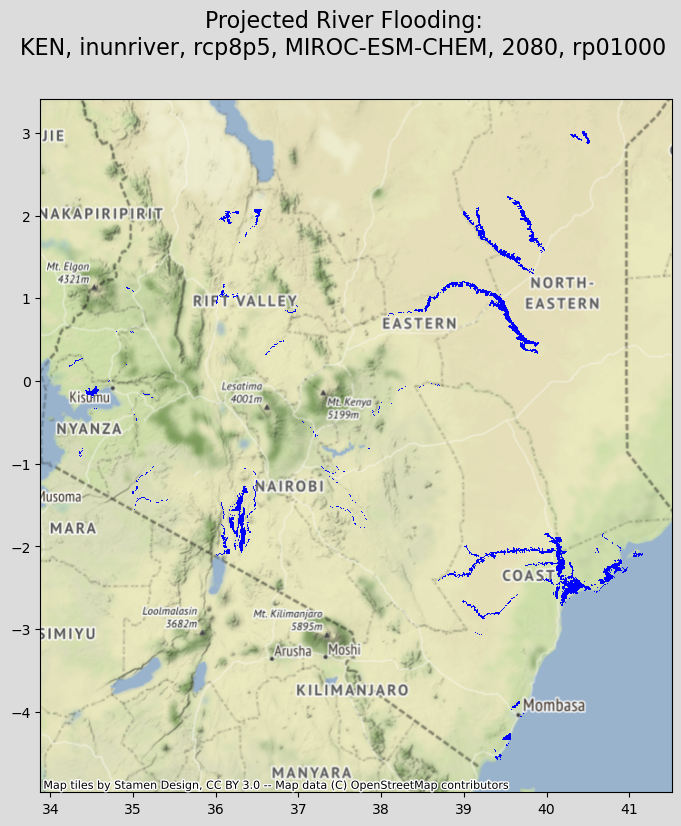

In [18]:
# Setup fig and axes, and define plot size
fig, ax = plt.subplots(1, 1, figsize=(10, 9)) 
fig.set_facecolor('gainsboro')

# Import hazard and plot 
hazard = gpd.read_file(path_in, crs='epsg:4326') 
hazard = hazard.to_crs(4326)
hazard.plot(color='blue', linewidth=1.5, alpha=.7, legend=True, edgecolor=None, ax=ax)

cx.add_basemap(ax, crs = 'epsg:4326', source = cx.providers.Stamen.Terrain)

# Subset scenario strings for title
hazard_type = filename.split('_')[0]
scenario = filename.split('_')[1]
model = filename.split('_')[2]
year = filename.split('_')[3]
return_period = filename.split('_')[4]
return_period = return_period.replace('.shp', '')

# Insert scenario strings in title
main_title = 'Projected River Flooding:\n{}, {}, {}, {}, {}, {}'.format(
    'KEN', hazard_type, scenario, model, year, return_period
)
plt.suptitle(main_title, fontsize=16, wrap=True)

In [19]:
filename = 'population.csv'
path_in = os.path.join('data', 'processed', 'KEN', filename) 
data = pd.read_csv(path_in)

In [20]:
filename = 'gadm_{}.shp'.format(1)
path_in = os.path.join('data', 'processed', 'KEN', 'regions', filename) 
country_boundaries = gpd.read_file(path_in)

In [29]:
pop_bound_flood_100 = country_boundaries.merge(data, left_on='GID_0', right_on='GID_1')

In [ ]:
folder = os.path.join('data', 'processed', 'KEN', 'hazards', 'inunriver', 'shapefiles')
filename = 'inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000.shp'
path_in = os.path.join(folder, filename)

In [31]:
intersection = gpd.overlay(pop_bound_flood_100, hazard, how = 'intersection')
folder = os.path.join('data', 'processed', 'KEN', 'hazards', 'inunriver', 'shapefiles', 'intersection')
if not os.path.exists(folder):
    os.mkdir(folder)
output_path = os.path.join(folder, 'intersection_inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000.shp')
intersection.to_file(output_path, crs = 'epsg:4326')

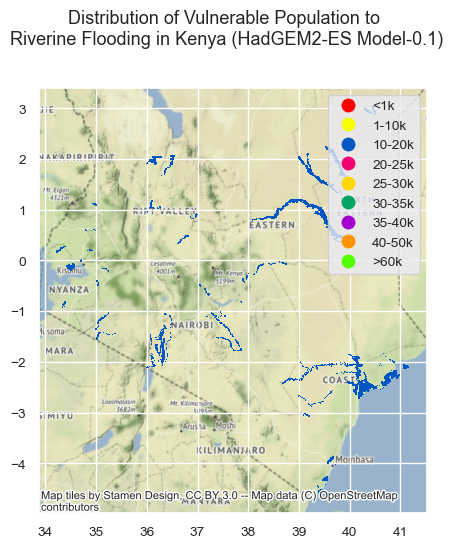

In [33]:
bins = [-1e6, 1000, 10000, 200000, 250000, 300000, 350000,        
        400000, 500000, 600000]
labels = ['<1k','1-10k','10-20k','20-25k', '25-30k', 
          '30-35k', '35-40k', '40-50k', '>60k']

#create a new variable with our bin labels
intersection['bin'] = pd.cut(intersection['population'], bins=bins, labels=labels)

#open a new seaborn figure
sns.set(font_scale = 0.9)
fig, ax = plt.subplots(1, 1, figsize = (5, 6))

#now plot our data using pandas plot
base = intersection.plot(column = 'bin', ax = ax, cmap = 'prism', linewidth = 0, #inferno_r
    legend = True, antialiased = False)
cx.add_basemap(ax, crs = 'epsg:4326', source = cx.providers.Stamen.Terrain)

#allocate a plot title 
n = len(intersection)
name = 'Distribution of Vulnerable Population to \nRiverine Flooding in Kenya (HadGEM2-ES Model-0.1)'
fig.suptitle(name)
plt.suptitle(name, fontsize = 13, wrap =True)

#specify where to write our .png file to
#path = os.path.join('data', 'processed', 'KEN', 'hadgem_100_pop_flood_fig.png')
#fig.savefig(path)
plt.close(fig)
fig

In [ ]:
path = os.path.join('data', 'raw', 'countries.csv')
countries = pd.read_csv(path, encoding='latin-1')

for idx, country in countries.iterrows():
    
    if not country['iso3'] == 'RWA': # if the current country iso3 does not match RWA...
        continue                     # continue in the loop to the next country 
    
    iso3 = country['iso3']
    
    folder = os.path.join('data', 'processed', iso3, 'hazards', 'inunriver')
    if not os.path.exists(folder):
        os.mkdir(folder)
    filename = 'inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000.shp'
    path_out = os.path.join(folder, filename)

    folder = os.path.join('data', 'processed', iso3, 'hazards', 'inunriver')
    if not os.path.exists(folder):
        os.mkdir(folder)
    filename = 'inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000.tif'
    path_in = os.path.join(folder, filename)

    with rasterio.open(path_in) as src:

        affine = src.transform
        array = src.read(1)

        output = []

        for vec in rasterio.features.shapes(array):

            if vec[1] > 0 and not vec[1] == 255:

                coordinates = [i for i in vec[0]['coordinates'][0]]

                coords = []

                for i in coordinates:

                    x = i[0]
                    y = i[1]

                    x2, y2 = src.transform * (x, y)

                    coords.append((x2, y2))

                output.append({
                    'type': vec[0]['type'],
                    'geometry': {
                        'type': 'Polygon',
                        'coordinates': [coords],
                    },
                    'properties': {
                        'value': vec[1],
                    }
                })

    output = gpd.GeoDataFrame.from_features(output, crs='epsg:4326')
    output.to_file(path_out, driver='ESRI Shapefile')